## 数据预处理与特征工程


In [1]:
import numpy as np
import pandas as pd

### 一、数据预处理

1、无量纲化处理

+ 归一化MinMaxScaler

In [2]:
from sklearn.preprocessing import MinMaxScaler

data = pd.DataFrame([[-1, 2], [-0.5, 6], [0, 10], [1, 18]])
scaler=MinMaxScaler(feature_range=[0,1]) # 默认feature_range就是[0,1]
result=scaler.fit_transform(data)

result

array([[0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [1.  , 1.  ]])

In [3]:
# 归一化逆变换
result_=scaler.inverse_transform(result)

result_

array([[-1. ,  2. ],
       [-0.5,  6. ],
       [ 0. , 10. ],
       [ 1. , 18. ]])

+ 标准化

In [4]:
from sklearn.preprocessing import StandardScaler
data = pd.DataFrame([[-1, 2], [-0.5, 6], [0, 10], [1, 18]])

scaler=StandardScaler()
scaler.fit(data)
print('原数据均值:{},方差:{}'.format(scaler.mean_,scaler.var_))

data_std=scaler.transform(data)
print('数据标准化后均值:{},标准差:{}'.format(data_std.mean(),data_std.std()))

原数据均值:[-0.125  9.   ],方差:[ 0.546875 35.      ]
数据标准化后均值:0.0,标准差:1.0


In [5]:
data_=scaler.inverse_transform(data_std)

data_

array([[-1. ,  2. ],
       [-0.5,  6. ],
       [ 0. , 10. ],
       [ 1. , 18. ]])

2、缺失值处理

In [6]:
data = pd.read_csv(r".\Narrativedata.csv"
                   ,index_col=0
                  )#index_col=0将第0列作为索引，不写则认为第0列为特征
 
data.head()

,Age,Sex,Embarked,Survived
0,22.0,male,S,No
1,38.0,female,C,Yes
2,26.0,female,S,Yes
3,35.0,female,S,Yes
4,35.0,male,S,No


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 4 columns):
Age         714 non-null float64
Sex         891 non-null object
Embarked    889 non-null object
Survived    891 non-null object
dtypes: float64(1), object(3)
memory usage: 34.8+ KB


In [8]:
# Age与Embarked具有缺失值，此处使用均值填充Age，众数填充Embarked
from sklearn.impute import SimpleImputer

imputer_mean=SimpleImputer(missing_values=np.nan,strategy='mean')
# 注意输入是2-D数据
data.loc[:,'Age']=imputer_mean.fit_transform(data['Age'].values.reshape(-1,1))

imputer_most=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
data.loc[:,'Embarked']=imputer_most.fit_transform(data['Embarked'].values.reshape(-1,1))

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 4 columns):
Age         891 non-null float64
Sex         891 non-null object
Embarked    891 non-null object
Survived    891 non-null object
dtypes: float64(1), object(3)
memory usage: 34.8+ KB


3、多列标签编码

In [9]:
# 此时的data是处理完缺失值后的数据
data.head()

,Age,Sex,Embarked,Survived
0,22.0,male,S,No
1,38.0,female,C,Yes
2,26.0,female,S,Yes
3,35.0,female,S,Yes
4,35.0,male,S,No


In [10]:
from sklearn.preprocessing import OrdinalEncoder
oe=OrdinalEncoder()
# 对类别型数据（后三列）进行标签编码
oe.fit(data.iloc[:,1:])
oe.categories_

[array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object),
 array(['No', 'Unknown', 'Yes'], dtype=object)]

In [11]:
data.iloc[:,1:]=oe.fit_transform(data.iloc[:,1:])
data.head()

,Age,Sex,Embarked,Survived
0,22.0,1.0,2.0,0.0
1,38.0,0.0,0.0,2.0
2,26.0,0.0,2.0,2.0
3,35.0,0.0,2.0,2.0
4,35.0,1.0,2.0,0.0


4、特殊用法之分箱编码

In [12]:
from sklearn.preprocessing import KBinsDiscretizer
 
X = data.iloc[:,0].values.reshape(-1,1) 
# 分箱后标签编码
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
est.fit_transform(X)[:5,:]
 

array([[0.],
       [1.],
       [0.],
       [1.],
       [1.]])

In [13]:
#查看转换后分的箱：变成了一列中的三箱
set(est.fit_transform(X).ravel())

{0.0, 1.0, 2.0}

In [14]:
est = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='uniform')
#查看转换后分的箱：变成了哑变量（独热编码）
est.fit_transform(X).toarray()[:5,:]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

### 二、特征选择

主要分为Filter过滤法、Embedded嵌入法、Wrapper包装法。

In [15]:
import pandas as pd
data = pd.read_csv(r".\digit recognizor.csv")
 
X = data.iloc[:,1:]
y = data.iloc[:,0]
 
X.shape

(42000, 784)

1、Filter过滤法

+  方差过滤

In [16]:
from sklearn.feature_selection import VarianceThreshold

selector=VarianceThreshold() # 默认阈值为0
x_var_0=selector.fit_transform(X)

x_var_0.shape

(42000, 708)

In [17]:
# 设置阈值为所有列方差中值，即保留一半特征
selector=VarianceThreshold(threshold=np.median(X.var().values))
x_var_median=selector.fit_transform(X)

x_var_median.shape

(42000, 392)

In [18]:
# 若特征是伯努利随机变量（此处由于图像数据是0-1二值量），
# 假设p=0.8，即二分类特征中某种分类占到80%以上的时候删除特征
selector=VarianceThreshold(threshold=0.8*(1-0.8))
x_var_bn=selector.fit_transform(X)

x_var_bn.shape

(42000, 685)

In [19]:
# 交叉验证分数比较
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

print('***** 随机森林交叉验证分数 *****')
print('原始数据:',cross_val_score(RandomForestClassifier(random_state=78,n_estimators=10), X ,y,cv=5).mean())
print('zero thresh:',cross_val_score(RandomForestClassifier(random_state=78,n_estimators=10), x_var_0 ,y,cv=5).mean())
print('median thresh:',cross_val_score(RandomForestClassifier(random_state=78,n_estimators=10), x_var_median ,y,cv=5).mean())
print('bonuli thresh:',cross_val_score(RandomForestClassifier(random_state=78,n_estimators=10), x_var_bn ,y,cv=5).mean())

***** 随机森林交叉验证分数 *****
原始数据: 0.9384285714285715
zero thresh: 0.9388333333333334
median thresh: 0.9392619047619049
bonuli thresh: 0.9390476190476191


此处实验时采用随机森林基学习器数目较少，是为了节省运算时间。通过比较验证分数，
可以发现，阈值取方差中值时甚至比原始数据效果要好。


+ 卡方过滤

In [21]:
from sklearn.feature_selection import SelectKBest,chi2

# 卡方过滤选择其前300个特征
selector=SelectKBest(chi2,k=300)
x_chi_k=selector.fit_transform(x_var_median,y)
x_chi_k.shape

(42000, 300)

In [22]:
cross_val_score(RandomForestClassifier(random_state=78,n_estimators=10), x_chi_k ,y,cv=5).mean()

0.9336904761904761

通过验证分数可以发现性能有所下降，说明选择的特征中包含有效特征。我们可以通过P值确定k值。

In [26]:
chi_score,pvalue=chi2(x_var_median,y)
# 选取p不大于0.05的特征
k=x_var_median.shape[1]-(pvalue>0.05).sum()

k

392

卡方过滤之前数据维度已经是392了，也就是说目前剩余的所有特征都与标签相关。

In [27]:
selector=SelectKBest(chi2,k=k)
x_chi_k=selector.fit_transform(x_var_median,y)
x_chi_k.shape

(42000, 392)

In [28]:
cross_val_score(RandomForestClassifier(random_state=78,n_estimators=10), x_chi_k ,y,cv=5).mean()

0.9392619047619049

+ F检验

In [29]:
from sklearn.feature_selection import f_classif

f_score,pvalue=f_classif(x_var_median,y)
# 选取p不大于0.05的特征
k=x_var_median.shape[1]-(pvalue>0.05).sum()

k

392

F检验得到和卡方过滤一样的结果

+ 互信息法

In [30]:
from sklearn.feature_selection import mutual_info_classif as MIC

info=MIC(x_var_median,y)
# 选取互信息大于0的特征
k=x_var_median.shape[1]-(info<=0).sum()

k

392

和之前的结果一致，所以通过方差过滤得到的新数据表现较好。

2、embedded嵌入法

In [31]:
from sklearn.feature_selection import SelectFromModel

rfc=RandomForestClassifier(n_estimators=10,random_state=78)
# 选择随机森林feature_importances_>0.005的特征，该阈值其实很大
x_embedded=SelectFromModel(rfc,threshold=0.005).fit_transform(X,y)
x_embedded.shape
# 784个特征仅选择52个

(42000, 52)

In [33]:
cross_val_score(rfc,x_embedded,y,cv=5).mean()
# 验证分数果然比较差

0.8975000000000002

阈值超参数调参

特征数：784，验证分数：0.9384285714285715
特征数：304，验证分数：0.9374285714285715
特征数：224，验证分数：0.9332619047619047
特征数：160，验证分数：0.9305
特征数：121，验证分数：0.9246190476190476
特征数：87，验证分数：0.9177380952380952
特征数：64，验证分数：0.9060952380952381
特征数：49，验证分数：0.894452380952381
特征数：29，验证分数：0.862642857142857
特征数：22，验证分数：0.8318333333333333
特征数：14，验证分数：0.7655238095238095
特征数：12，验证分数：0.7382142857142858
特征数：7，验证分数：0.6172380952380953
特征数：3，验证分数：0.3847380952380952
特征数：3，验证分数：0.3847380952380952
特征数：3，验证分数：0.3847380952380952
特征数：3，验证分数：0.3847380952380952
特征数：3，验证分数：0.3847380952380952
特征数：1，验证分数：0.21940476190476188
特征数：1，验证分数：0.21940476190476188


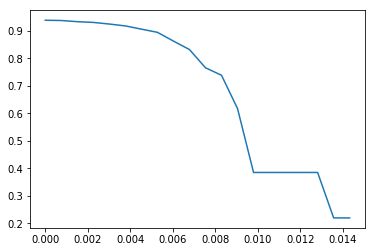

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

rfc.fit(X,y)
th=np.linspace(0,rfc.feature_importances_.max(),20)

scores=[]
for t in th:
    x_embedded=SelectFromModel(rfc,threshold=t).fit_transform(X,y)
    score=cross_val_score(rfc,x_embedded,y,cv=5).mean()
    scores.append(score)
    print('特征数：{}，验证分数：{}'.format(x_embedded.shape[1],score))

plt.figure()
plt.plot(th,scores)
plt.show()

观察图像，可以发现0-0.004之间验证分数变化不大，可以缩小至0-0.001之间继续调参。

特征数：784，验证分数：0.9384285714285715
特征数：483，验证分数：0.9392619047619046
特征数：445，验证分数：0.9400000000000001
特征数：422，验证分数：0.9395238095238094
特征数：400，验证分数：0.9396190476190476
特征数：385，验证分数：0.9394523809523809
特征数：373，验证分数：0.9382857142857143
特征数：366，验证分数：0.9383571428571429
特征数：357，验证分数：0.939595238095238
特征数：349，验证分数：0.9391904761904761
特征数：339，验证分数：0.9388095238095238
特征数：331，验证分数：0.9400952380952381
特征数：323，验证分数：0.9378333333333334
特征数：312，验证分数：0.9383809523809523
特征数：305，验证分数：0.9385
特征数：300，验证分数：0.9384523809523809
特征数：294，验证分数：0.9404523809523809
特征数：288，验证分数：0.9376190476190477
特征数：283，验证分数：0.9361428571428572
特征数：276，验证分数：0.9383333333333332


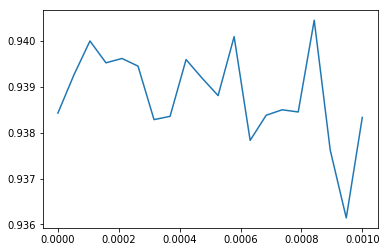

In [35]:
th=np.linspace(0,0.001,20)

scores=[]
for t in th:
    x_embedded=SelectFromModel(rfc,threshold=t).fit_transform(X,y)
    score=cross_val_score(rfc,x_embedded,y,cv=5).mean()
    scores.append(score)
    print('特征数：{}，验证分数：{}'.format(x_embedded.shape[1],score))

plt.figure()
plt.plot(th,scores)
plt.show()

In [37]:
rfc=RandomForestClassifier(n_estimators=10,random_state=78)
# 选择随机森林feature_importances_>0.005的特征，该阈值其实很大
x_embedded=SelectFromModel(rfc,threshold=th[np.argmax(scores)]).fit_transform(X,y)

cross_val_score(rfc,x_embedded,y,cv=5).mean()

0.9404523809523809

进一步调参得到的验证分数有所提升。

3、wrapper包裹法

In [38]:
# 递归特征消除
from sklearn.feature_selection import RFE
rfc = RandomForestClassifier(n_estimators =10,random_state=78)
selector = RFE(rfc , n_features_to_select=340, step=50)
x_wrapper=selector.fit_transform(X, y)

x_wrapper.shape

(42000, 340)

In [39]:
cross_val_score(rfc,x_wrapper,y,cv=5).mean()

0.938595238095238

特征数：1，验证分数：0.17659523809523808
特征数：51，验证分数：0.9008095238095238
特征数：101，验证分数：0.9226190476190477
特征数：151，验证分数：0.9284285714285714
特征数：201，验证分数：0.9334523809523809
特征数：251，验证分数：0.9374761904761904
特征数：301，验证分数：0.9377619047619048
特征数：351，验证分数：0.9392619047619049
特征数：401，验证分数：0.9400000000000001
特征数：451，验证分数：0.9376428571428571
特征数：501，验证分数：0.9394761904761906
特征数：551，验证分数：0.9375714285714285
特征数：601，验证分数：0.9401190476190477
特征数：651，验证分数：0.9377380952380954
特征数：701，验证分数：0.9375714285714285
0.9401190476190477


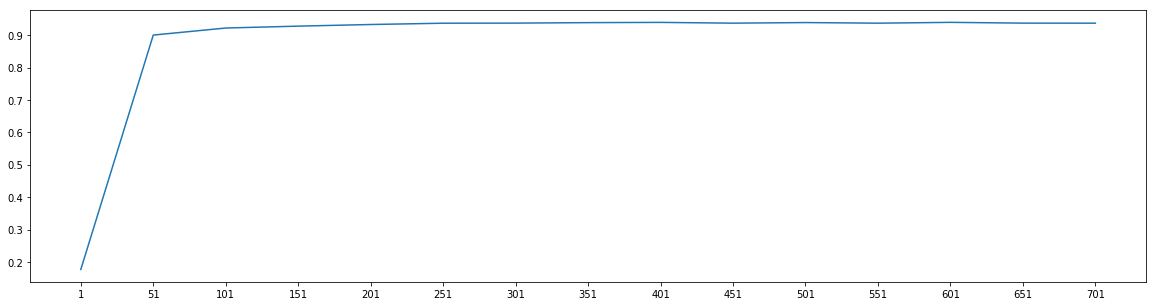

In [41]:
select_feature=np.arange(1,751,50)

scores=[]
for t in select_feature:
    x_wrapper=RFE(rfc,n_features_to_select=t, step=50).fit_transform(X,y)
    score=cross_val_score(rfc,x_wrapper,y,cv=5).mean()
    scores.append(score)
    print('特征数：{}，验证分数：{}'.format(x_wrapper.shape[1],score))

plt.figure(figsize=(20,5))
plt.plot(select_feature,scores)
plt.xticks(select_feature)
plt.show()
print(np.max(scores))